In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 80

ng =7

ng_refs = (/ 7 /) 

nref =1

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

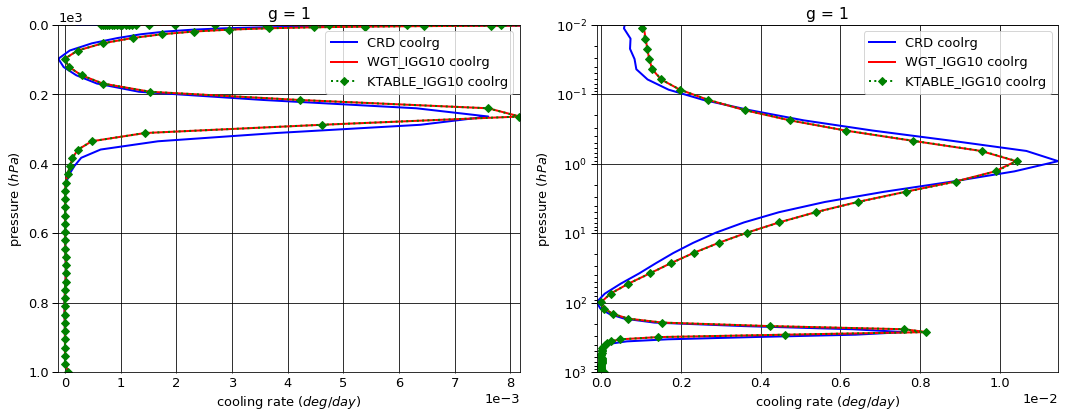

# Figure: cooling rate g-group 2

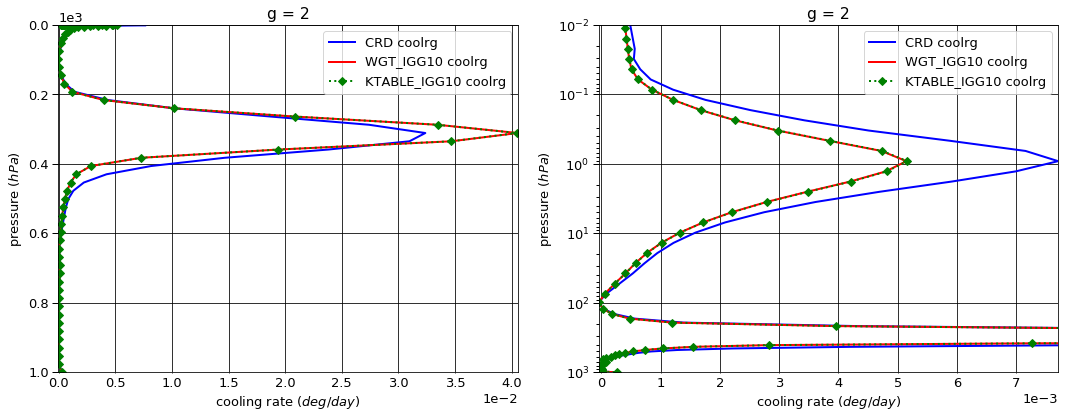

# Figure: cooling rate g-group 3

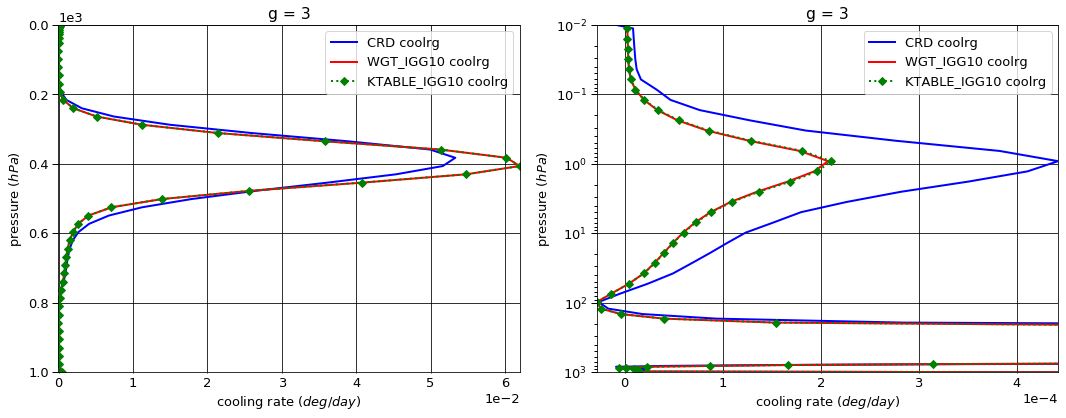

# Figure: cooling rate g-group 4

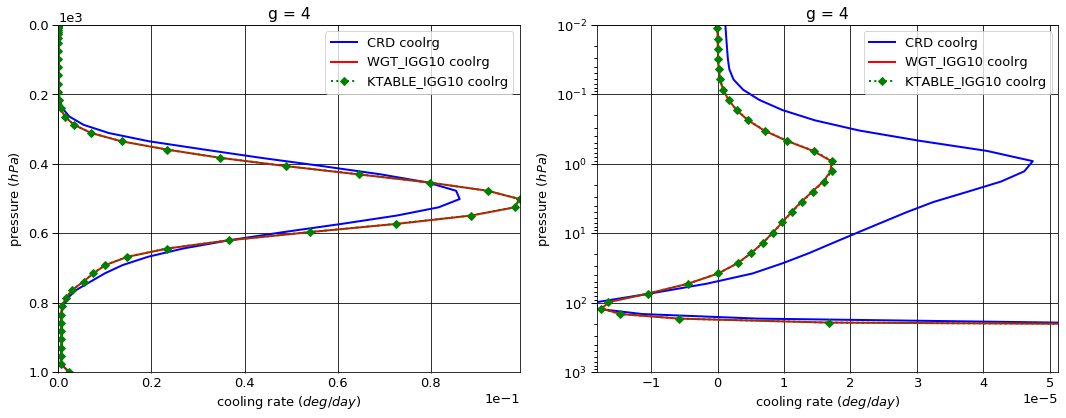

# Figure: cooling rate g-group 5

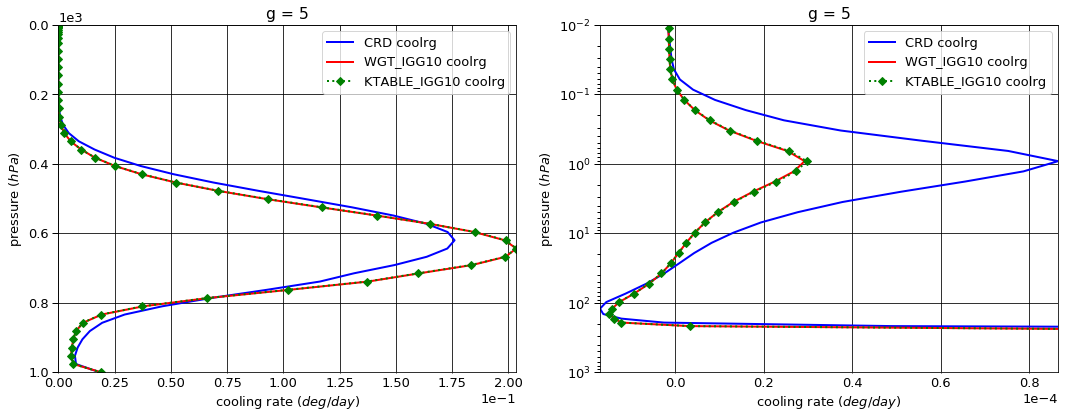

# Figure: cooling rate g-group 6

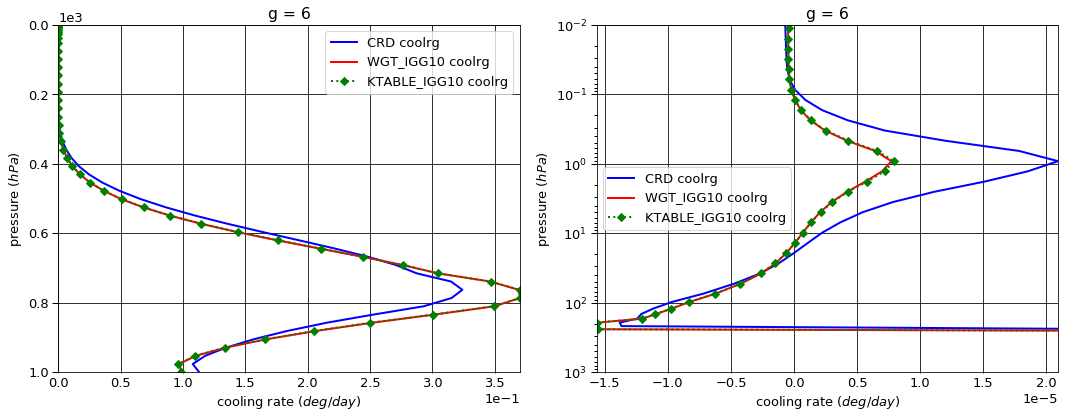

# Figure: cooling rate g-group 7

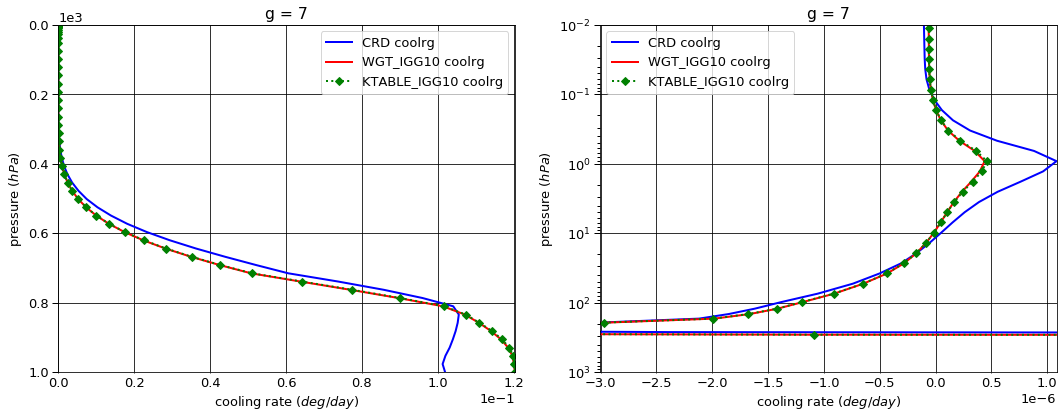

# Figure: cooling rate g-group total

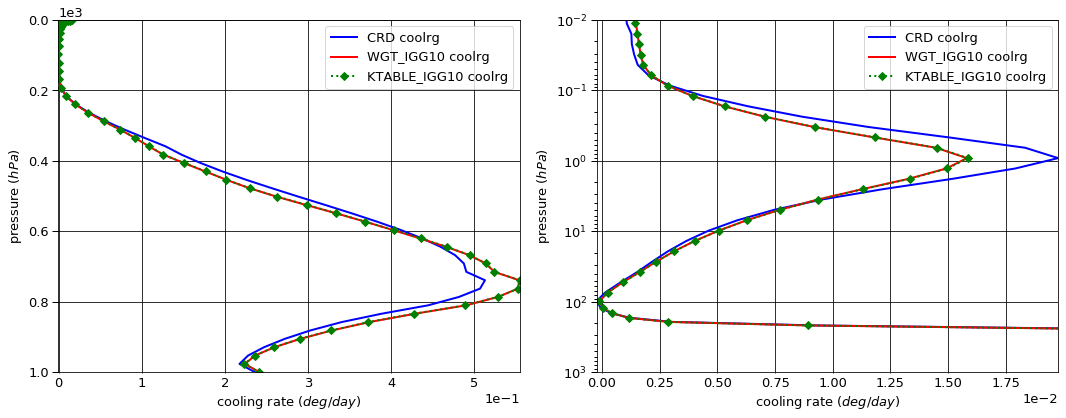

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.105648   0.000000  -0.105648
  1013.0   76     -0.259884   0.259712  -0.000173
2 0.0      1      -0.525783   0.000000  -0.525783
  1013.0   76     -1.099170   1.098435  -0.000734
3 0.0      1      -1.145519   0.000000  -1.145519
  1013.0   76     -2.039552   2.038190  -0.001362
4 0.0      1      -2.489714   0.000000  -2.489714
  1013.0   76     -3.830348   3.824514  -0.005834
5 0.0      1      -6.427599   0.000000  -6.427599
  1013.0   76     -8.649567   8.589558  -0.060009
6 0.0      1     -13.316212   0.000000 -13.316212
  1013.0   76    -16.017142  15.256634  -0.760508
7 0.0      1      -5.979825   0.000000  -5.979825
  1013.0   76     -6.596071   4.833970  -1.762101


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.100663   0.000000  -0.100663
  1013.0   76     -0.259884   0.259712  -0.000173
2 0.0      1      -0.515360   0.000000  -0.515360
  1013.0   76     -1.099170   1.098435  -0.000734
3 0.0      1      -1.150982   0.000000  -1.150982
  1013.0   76     -2.039552   2.038190  -0.001362
4 0.0      1      -2.516544   0.000000  -2.516544
  1013.0   76     -3.830348   3.824301  -0.006047
5 0.0      1      -6.513885   0.000000  -6.513885
  1013.0   76     -8.649567   8.593671  -0.055896
6 0.0      1     -13.400941   0.000000 -13.400941
  1013.0   76    -16.017142  15.517734  -0.499408
7 0.0      1      -6.039089   0.000000  -6.039089
  1013.0   76     -6.596071   4.784146  -1.811925


KTABLE_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.100632   0.000000  -0.100632
  1013.0   76     -0.259884   0.259712  -0.000173
2 0.0      1      -0.515260   0.000000  -0.515260
  1013.0   76     -1.099170   1.098435  -0.000734
3 0.0      1      -1.150659   0.000000  -1.150659
  1013.0   76     -2.039552   2.038190  -0.001362
4 0.0      1      -2.515810   0.000000  -2.515810
  1013.0   76     -3.830348   3.824309  -0.006039
5 0.0      1      -6.511520   0.000000  -6.511520
  1013.0   76     -8.649567   8.593884  -0.055683
6 0.0      1     -13.396018   0.000000 -13.396018
  1013.0   76    -16.017142  15.522209  -0.494933
7 0.0      1      -6.036873   0.000000  -6.036873
  1013.0   76     -6.596071   4.798551  -1.797520


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.985440e-03  0.000000  0.004985
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      1.042294e-02  0.000000  0.010423
  1013.0   76     0.000000e+00  0.000000  0.000000
3 0.0      1     -5.462800e-03  0.000000 -0.005463
  1013.0   76     0.000000e+00  0.000000  0.000000
4 0.0      1     -2.683030e-02  0.000000 -0.026830
  1013.0   76     4.440892e-16 -0.000213 -0.000213
5 0.0      1     -8.628580e-02  0.000000 -0.086286
  1013.0   76     0.000000e+00  0.004113  0.004113
6 0.0      1     -8.472900e-02  0.000000 -0.084729
  1013.0   76     0.000000e+00  0.261100  0.261100
7 0.0      1     -5.926380e-02  0.000000 -0.059264
  1013.0   76     0.000000e+00 -0.049824 -0.049824


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.015970e-03  0.000000  0.005016
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      1.052254e-02  0.000000  0.010523
  1013.0   76     0.000000e+00  0.000000  0.000000
3 0.0      1     -5.140100e-03  0.000000 -0.005140
  1013.0   76     0.000000e+00  0.000000  0.000000
4 0.0      1     -2.609570e-02  0.000000 -0.026096
  1013.0   76     4.440892e-16 -0.000205 -0.000205
5 0.0      1     -8.392100e-02  0.000000 -0.083921
  1013.0   76     0.000000e+00  0.004326  0.004326
6 0.0      1     -7.980600e-02  0.000000 -0.079806
  1013.0   76     0.000000e+00  0.265575  0.265575
7 0.0      1     -5.704750e-02  0.000000 -0.057047
  1013.0   76     0.000000e+00 -0.035419 -0.035419

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      2.837945e-04
  1001.112500 75     6.206312e-05
2 0.000312    1      3.501072e-04
  1001.112500 75     2.634922e-04
3 0.000312    1      3.794393e-06
  1001.112500 75     4.889458e-04
4 0.000312    1      4.494171e-07
  1001.112500 75     2.323699e-03
5 0.000312    1     -3.291338e-06
  1001.112500 75     1.840998e-02
6 0.000312    1     -8.561572e-07
  1001.112500 75     1.130399e-01
7 0.000312    1     -1.183283e-07
  1001.112500 75     1.019533e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      7.557642e-04
  1001.112500 75     6.206312e-05
2 0.000312    1      2.493990e-04
  1001.112500 75     2.634922e-04
3 0.000312    1      6.446696e-07
  1001.112500 75     4.889458e-04
4 0.000312    1     -2.670133e-07
  1001.112500 75     2.375118e-03
5 0.000312    1     -2.075645e-06
  1001.112500 75     1.897759e-02
6 0.000312    1     -5.167828e-07
  1001.112500 75     9.934553e-02
7 0.000312    1     -6.749782e-08
  1001.112500 75     1.203549e-01


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      6.528644e-04
  1001.112500 75     6.206312e-05
2 0.000312    1      2.185937e-04
  1001.112500 75     2.634922e-04
3 0.000312    1      2.191007e-07
  1001.112500 75     4.889458e-04
4 0.000312    1     -1.770542e-07
  1001.112500 75     2.371651e-03
5 0.000312    1     -1.753863e-06
  1001.112500 75     1.892155e-02
6 0.000312    1     -3.392543e-07
  1001.112500 75     9.875970e-02
7 0.000312    1     -5.971654e-08
  1001.112500 75     1.203288e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.719697e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.007083e-04
  1001.112500 75     0.000000e+00
3 0.000312    1     -3.149723e-06
  1001.112500 75     0.000000e+00
4 0.000312    1     -7.164303e-07
  1001.112500 75     5.141980e-05
5 0.000312    1      1.215693e-06
  1001.112500 75     5.676110e-04
6 0.000312    1      3.393744e-07
  1001.112500 75    -1.369437e-02
7 0.000312    1      5.083051e-08
  1001.112500 75     1.840160e-02


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.690700e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.315135e-04
  1001.112500 75     0.000000e+00
3 0.000312    1     -3.575292e-06
  1001.112500 75     0.000000e+00
4 0.000312    1     -6.264713e-07
  1001.112500 75     4.795240e-05
5 0.000312    1      1.537476e-06
  1001.112500 75     5.115680e-04
6 0.000312    1      5.169029e-07
  1001.112500 75    -1.428019e-02
7 0.000312    1      5.861179e-08
  1001.112500 75     1.837552e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.990301,0.000000,-29.990301
1013.0,76,-38.491734,35.901013,-2.590721



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.237464,0.000000,-30.237464
1013.0,76,-38.491734,36.116189,-2.375545



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.226773,0.00000,-30.226773
1013.0,76,-38.491734,36.13529,-2.356444



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.471633e-01,0.000000,-0.247163
1013.0,76,7.105427e-15,0.215176,0.215176



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.364718e-01,0.000000,-0.236472
1013.0,76,7.105427e-15,0.234277,0.234277


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000634
1001.112500,75,0.236541



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001003
1001.112500,75,0.241868



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000869
1001.112500,75,0.241196



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000369
1001.112500,75,0.005326



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000235
1001.112500,75,0.004655


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.006750,0.006798
2,0.028563,0.028687
3,0.053000,0.053233
4,0.099562,0.100153
5,0.224750,0.225604
6,0.416125,0.416491
7,0.171250,0.169035


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.643251e-21
2,1.773812e-21
3,4.116584e-22
4,9.553585e-23
5,2.217154e-23
6,5.145472e-24
7,1.194138e-24


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.643251e-21,NaN,0.006750,0.006798,0.006750,0.006798,600.0
2,1.773812e-21,0.232076,0.028563,0.028687,0.035313,0.035485,600.0
3,4.116584e-22,0.232076,0.053000,0.053233,0.088313,0.088718,600.0
4,9.553585e-23,0.232076,0.099562,0.100153,0.187875,0.188871,600.0
5,2.217154e-23,0.232076,0.224750,0.225604,0.412625,0.414475,600.0
6,5.145472e-24,0.232076,0.416125,0.416491,0.828750,0.830965,600.0
7,1.194138e-24,0.232076,0.171250,0.169035,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.116662e-20  5.423658e-22  20.588715  5.521180e-07
      2 0.000312     1.672802e-21  3.546342e-23  47.169792  8.175899e-08
      3 0.000312     1.309242e-23  1.319623e-24   9.921340  6.615296e-10
      4 0.000312     1.436809e-24  1.971404e-25   7.288252  5.652927e-11
      5 0.000312     2.105660e-24  1.237100e-25  17.020939  7.712889e-11
      6 0.000312     1.601385e-25  1.652251e-26   9.692142  6.111890e-12
      7 0.000312     3.498072e-26  4.191472e-27   8.345688  1.355229e-12
2     1 0.000750     1.123498e-20  5.431075e-22  20.686476  2.237257e-07
      2 0.000750     1.682436e-21  3.549792e-23  47.395338  3.311967e-08
      3 0.000750     1.327212e-23  1.324791e-24  10.018274  2.700042e-10
      4 0.000750     1.450592e-24  1.980248e-25   7.325305  2.297363e-11
      5 0.000750     2.118194e-24  1.241182e-25  17.065945  3.124684e-11
      6 0.000750     1.616078e-25  1.661923e-26   9.724146  2.483611e-12
      7 0.000750     3.515356e-26  4.211872e-27   8.346304  5.485611e-13
3     1 0.001052     1.137425e-20  5.443764e-22  20.894088  3.175749e-07
      2 0.001052     1.702136e-21  3.554336e-23  47.888994  4.698606e-08
      3 0.001052     1.364044e-23  1.333123e-24  10.231950  3.888248e-10
      4 0.001052     1.478506e-24  1.996547e-25   7.405313  3.279525e-11
      5 0.001052     2.143848e-24  1.249091e-25  17.163274  4.433692e-11
      6 0.001052     1.646206e-25  1.680501e-26   9.795925  3.545487e-12
      7 0.001052     3.550257e-26  4.251356e-27   8.350880  7.768863e-13
4     1 0.001476     1.151678e-20  5.457076e-22  21.104298  4.510157e-07
      2 0.001476     1.722284e-21  3.559433e-23  48.386473  6.669053e-08
      3 0.001476     1.402356e-23  1.342001e-24  10.449738  5.603300e-10
      4 0.001476     1.507322e-24  2.013542e-25   7.485922  4.684481e-11
      5 0.001476     2.170181e-24  1.257279e-25  17.260938  6.294428e-11
      6 0.001476     1.677362e-25  1.699596e-26   9.869186  5.064590e-12
      7 0.001476     3.586181e-26  4.292926e-27   8.353698  1.100876e-12
5     1 0.002070     1.166068e-20  5.471027e-22  21.313519  6.403680e-07
      2 0.002070     1.742608e-21  3.565260e-23  48.877434  9.463472e-08
      3 0.002070     1.441690e-23  1.351522e-24  10.667158  8.073064e-10
      4 0.002070     1.536699e-24  2.031182e-25   7.565541  6.690139e-11
      5 0.002070     2.196845e-24  1.265683e-25  17.356999  8.934247e-11
      6 0.002070     1.709160e-25  1.719054e-26   9.942443  7.233280e-12
      7 0.002070     3.622707e-26  4.336330e-27   8.354315  1.559789e-12
6     1 0.002904     1.180595e-20  5.485928e-22  21.520433  9.092868e-07
      2 0.002904     1.763096e-21  3.572130e-23  49.356990  1.342971e-07
      3 0.002904     1.482084e-23  1.361954e-24  10.882045  1.163281e-09
      4 0.002904     1.566677e-24  2.049687e-25   7.643496  9.556193e-11
      5 0.002904     2.223837e-24  1.274359e-25  17.450633  1.268268e-10
      6 0.002904     1.741610e-25  1.739006e-26  10.014975  1.033219e-11
      7 0.002904     3.659892e-26  4.381919e-27   8.352259  2.210491e-12
7     1 0.004074     1.195261e-20  5.502221e-22  21.723242  1.291133e-06
      2 0.004074     1.783740e-21  3.580483e-23  49.818404  1.905790e-07
      3 0.004074     1.523597e-23  1.373672e-24  11.091421  1.676327e-09
      4 0.004074     1.597321e-24  2.069374e-25   7.718862  1.365194e-10
      5 0.004074     2.251154e-24  1.283388e-25  17.540710  1.800446e-10
      6 0.004074     1.774737e-25  1.759644e-26  10.085772  1.476000e-11
      7 0.004074     3.697821e-26  4.430184e-27   8.346880  3.133169e-12
8     1 0.005714     1.210078e-20  5.520533e-22  21.919591  1.833180e-06
      2 0.005714     1.804540e-21  3.590937e-23  50.252610  2.704187e-07
      3 0.005714     1.566333e-23  1.387202e-24  11.291309  2.415712e-09
      4 0.005714     1.628742e-24  2.090702e-25   7.790410  1.950542e-10
      5 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
